The following additional libraries are needed to run this
notebook. Note that running on Colab is experimental, please report a Github
issue if you have any problem.

In [ ]:
!pip install ..  # installing d2l


# Transformer
:label:`sec_transformer`

我们在 :numref:`subsec_cnn-rnn-self-attention` 中比较了 CNN、RNN 和 Self-Attention。值得注意的是，Self-Attention 同时享有并行计算和最短的最大路径长度。因此，自然而言，通过使用 Self-Attention 来设计深层架构是很有吸引力的。与之前仍然依赖 RNN 进行输入表示 :cite:`Cheng.Dong.Lapata.2016,Lin.Feng.Santos.ea.2017,Paulus.Xiong.Socher.2017` 的 Self-Attention 模型不同，Transformer 模型完全基于注意机制，没有任何卷积层或循环层 :cite:`Vaswani.Shazeer.Parmar.ea.2017`。尽管 Transformer 最初是应用于文本数据的序列学习，但在各种现代深度学习应用中它也普遍存在，例如语言、视觉、语音和强化学习领域。

## 模型

作为 encoder-decoder 架构的一个实例，Transformer 的整体架构在图 :numref:`fig_transformer` 中呈现。正如我们所看到的，Transformer 由编码器和解码器组成。与 :numref:`fig_s2s_attention_details` 中 Bahdanau 对序列到序列学习的关注点不同，在将输入（源）和输出（目标）序列嵌入添加到编码器和解码器之前，这些嵌入将被添加到基于 Self-Attention 而堆叠模块的编码器和解码器中。

![The Transformer architecture.](http://d2l.ai/_images/transformer.svg)
:width:`500px`
:label:`fig_transformer`

现在我们在 :numref:`fig_transformer` 中概述了变压器架构。从高层来看，变压器编码器是由多个相同层组成的堆栈，每层都有两个子层（两个子层表示为 $\mathrm{sublayer}$）。第一个是多头自我注意力集中，第二个是位置上的前馈网络。具体来说，在编码器的自我注意中，查询、键和值都来自前一个编码器层的输出。受 :numref:`sec_resnet` ResNet 设计的启发，两个子层周围都采用了残留连接。在变压器中，对于序列中任何位置的任何输入 $\mathbf{x} \in \mathbb{R}^d$，我们要求 $\mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$，以便剩余连接 $\mathbf{x} + \mathrm{sublayer}(\mathbf{x}) \in \mathbb{R}^d$ 是可行的。从残留连接中添加这一点之后立即进行层规范化 :cite:`Ba.Kiros.Hinton.2016`。因此，变压器编码器为输入序列的每个位置输出 $d$ 维矢量表示。

变压器解码器也是由多个相同层组成的堆栈，具有残留连接和层标准化。除了编码器中描述的两个子层之外，解码器还在这两个子层之间插入第三个子层，称为编码器解码器注意力。在编码器解码器中，查询来自前一个解码器层的输出，键和值来自 Transcoransder 编码器输出。在解码器中，查询、键和值都来自上一个解码器层的输出。但是，解码器中的每个位置只能处理解码器中直到该位置的所有位置。这种 * 掩码 * 注意力保留了自动回归属性，确保预测仅依赖于已生成的输出令牌。

我们已经描述并实施了基于 :numref:`sec_multihead-attention` 中的缩放点产品和 :numref:`subsec_positional-encoding` 中的位置编码的多头关注。在下面，我们将实现变压器模型的其余部分。


In [1]:
import math
import pandas as pd
import torch
from torch import nn
from d2l import torch as d2l

## 定位前馈网络

位置向前馈网络使用同一个 MLP 转换所有序列位置的表示形式。这就是为什么我们称之为 * 职位 *。在下面的实现中，带有形状的输入 `X`（批量大小、时间步长或序列长度（标记为单位的序列长度、隐藏单位数或要素维度）将被双层 MLP 转换为形状的输出张量（批量大小、时间步长、`ffn_num_outputs`）。


In [2]:
#@save
class PositionWiseFFN(nn.Module):
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

以下示例显示，张量的最内层维度会改变位置向前馈网络中的输出数量。由于相同的 MLP 在所有仓位上都变换，所以当所有这些位置的输入相同时，它们的输出也是相同的。


In [3]:
ffn = PositionWiseFFN(4, 4, 8)
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[ 0.2496, -0.1443, -0.5747,  0.5928, -0.1193, -0.0093, -0.2415,  0.0934],
        [ 0.2496, -0.1443, -0.5747,  0.5928, -0.1193, -0.0093, -0.2415,  0.0934],
        [ 0.2496, -0.1443, -0.5747,  0.5928, -0.1193, -0.0093, -0.2415,  0.0934]],
       grad_fn=<SelectBackward>)

## 剩余连接和层规范化

现在让我们关注 :numref:`fig_transformer` 中的 “添加和规范” 组件。正如我们在本节开头所述，这是一个残余连接，紧接着是层规范化。两者都是有效的深度架构的关键。

在 :numref:`sec_batch_norm` 中，我们解释了如何在一个小批量内批量标准化最近和重新调整示例。图层规范化与批量规范化相同，只是前者在要素维度上进行规范化。尽管在计算机视觉中广泛应用批量规范化，但在自然语言处理任务中，批量规范化通常不如图层规范化的效果，而自然语言处理任务的输入通常是可变长度的序列。

以下代码段通过层规范化和批量规范化比较了不同维度的规范化。


In [4]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# Compute mean and variance from `X` in the training mode
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward>)


现在我们可以使用剩余连接实现 `AddNorm` 类，然后再进行层规范化。退学也适用于正规化。


In [5]:
#@save
class AddNorm(nn.Module):
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

剩余连接要求两个输入的形状相同，以便在加法操作后输出张量也具有相同的形状。


In [6]:
add_norm = AddNorm([3, 4], 0.5)  # Normalized_shape is input.size()[1:]
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

## 编码器

由于组装变压器所需的所有必要组件，让我们首先在编码器中实现单层。以下 `EncoderBlock` 类包含两个子层：多头自我注意力和定位前馈网络，其中两个子层周围采用残留连接，然后再进行层规范化。


In [7]:
#@save
class EncoderBlock(nn.Module):
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        self.attention = d2l.MultiHeadAttention(key_size, query_size,
                                                value_size, num_hiddens,
                                                num_heads, dropout, use_bias)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, valid_lens):
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

正如我们所看到的，变压器编码器中的任何图层都不会改变其输入的形状。


In [8]:
X = torch.ones((2, 100, 24))
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

在下面的变压器编码器实现中，我们堆叠上述 `EncoderBlock` 类的 `num_layers` 个实例。由于我们使用的值始终在-1 和 1 之间的固定位置编码，因此我们将可学习输入嵌入的值乘以嵌入维度的平方根，以便在总结输入嵌入和位置编码之前重新缩放。


In [9]:
#@save
class TransformerEncoder(d2l.Encoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, use_bias))

    def forward(self, X, valid_lens, *args):
        # Since positional encoding values are between -1 and 1, the embedding
        # values are multiplied by the square root of the embedding dimension
        # to rescale before they are summed up
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

下面我们指定了超参数来创建一个双层变压器编码器。变压器编码器输出的形状是（批量大小、时间步长数、`num_hiddens`）。


In [10]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2,
                             0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

## 解码器

如 :numref:`fig_transformer` 所示，变压器解码器由多个相同的层组成。每个层都在以下 `DecoderBlock` 类中实现，其中包含三个子层：解码器自我注意、编码器-解码器注意力和定位前馈网络。这些子层周围使用残留连接，然后进行层规范化。

正如我们在本节前面所述，在蒙版的多头解码器自我注意力（第一个子层）中，查询、键和值都来自上一个解码器层的输出。训练顺序到序列模型时，输出序列的所有位置（时间步长）的令牌都是已知的。但是，在预测期间，输出序列是通过令牌生成的；因此，在任何解码器时间步骤中，只有生成的令牌才能用于解码器的自我注意力。为了在解码器中保留自动回归，其蒙版自我注意力指定 `dec_valid_lens`，以便任何查询只参与解码器中直到查询位置的所有位置。


In [11]:
class DecoderBlock(nn.Module):
    # The `i`-th block in the decoder
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size,
                                                 value_size, num_hiddens,
                                                 num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens,
                                   num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # During training, all the tokens of any output sequence are processed
        # at the same time, so `state[2][self.i]` is `None` as initialized.
        # When decoding any output sequence token by token during prediction,
        # `state[2][self.i]` contains representations of the decoded output at
        # the `i`-th block up to the current time step
        if state[2][self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = key_values
        if self.training:
            batch_size, num_steps, _ = X.shape
            # Shape of `dec_valid_lens`: (`batch_size`, `num_steps`), where
            # every row is [1, 2, ..., `num_steps`]
            dec_valid_lens = torch.arange(1, num_steps + 1,
                                          device=X.device).repeat(
                                              batch_size, 1)
        else:
            dec_valid_lens = None

        # Self-attention
        X2 = self.attention1(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # Encoder-decoder attention. Shape of `enc_outputs`:
        # (`batch_size`, `num_steps`, `num_hiddens`)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

为了便于在编码器-解码器注意和剩余连接中的加法操作，解码器的特征尺寸 (`num_hiddens`) 与编码器的特征尺寸 (`num_hiddens`) 相同。


In [12]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

现在我们构建了由 `num_layers` 个 `DecoderBlock` 实例组成的整个变压器解码器。最后，一个完全连接的层计算所有 `vocab_size` 个可能的输出令牌的预测。解码器的自我注意力重量和编码器-解码器的注意权重都被存储，以供日后可视化。


In [13]:
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(
                "block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]

    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # Decoder self-attention weights
            self._attention_weights[0][
                i] = blk.attention1.attention.attention_weights
            # Encoder-decoder attention weights
            self._attention_weights[1][
                i] = blk.attention2.attention.attention_weights
        return self.dense(X), state

    @property
    def attention_weights(self):
        return self._attention_weights

## 培训

让我们通过遵循变压器架构来实例化编码器解码器模型。在这里，我们指定变压器编码器和变压器解码器都有 2 层，使用 4 头注意力。与 :numref:`sec_seq2seq_training` 类似，我们训练变压器模型，以便在英语-法语机器翻译数据集上进行序列到序列的学习。


loss 0.032, 5288.9 tokens/sec on cuda:0


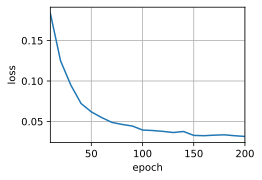

In [14]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, d2l.try_gpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4
key_size, query_size, value_size = 32, 32, 32
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)

encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size,
                             num_hiddens, norm_shape, ffn_num_input,
                             ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

训练结束后，我们使用变压器模型将一些英语句子翻译成法语并计算它们的 BLEU 分数。


In [15]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !,  bleu 1.000
i lost . => j'ai perdu .,  bleu 1.000
he's calm . => il est calme .,  bleu 1.000
i'm home . => je suis chez moi .,  bleu 1.000


让我们在将最后一个英语句子翻译成法语时可视化变压器的注意力重量。编码器自我注意权重的形状为（编码器层数、注意头数、`num_steps` 或查询数、`num_steps` 或键值对的数量）。


In [16]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape(
    (num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

在编码器的自我注意中，查询和键来自相同的输入序列。由于填充令牌不具有意义，并且输入序列的指定有效长度，因此没有查询参与填充令牌的位置。在以下内容中，将按行呈现两层多头注意力权重。每位负责人都根据查询、键和值的单独表示子空间独立出席。


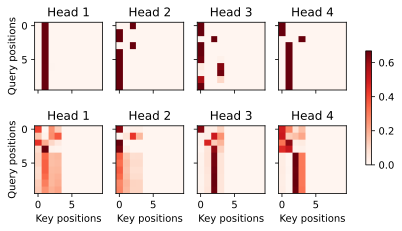

In [17]:
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

为了可视化解码器的自我注意力权重和编码器-解码器的注意权重，我们需要更多的数据操作。例如，我们用零填充蒙面的注意力重量。请注意，解码器自我注意权重和编码器注意权重都有相同的查询：序列开始令牌后跟输出令牌。


In [18]:
dec_attention_weights_2d = [
    head[0].tolist() for step in dec_attention_weight_seq for attn in step
    for blk in attn for head in blk]
dec_attention_weights_filled = torch.tensor(
    pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values)
dec_attention_weights = dec_attention_weights_filled.reshape(
    (-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = \
    dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

由于解码器自我注意的自动回归属性，查询位置后没有查询参与键值对。


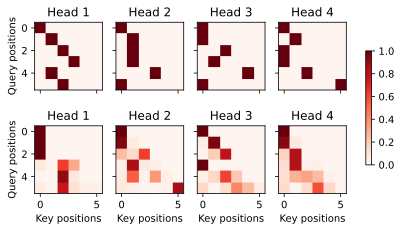

In [19]:
# Plus one to include the beginning-of-sequence token
d2l.show_heatmaps(
    dec_self_attention_weights[:, :, :, :len(translation.split()) + 1],
    xlabel='Key positions', ylabel='Query positions',
    titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

与编码器自我注意的情况类似，通过输入序列的指定有效长度，输出序列中的任何查询都不会参与输入序列中的填充标记。


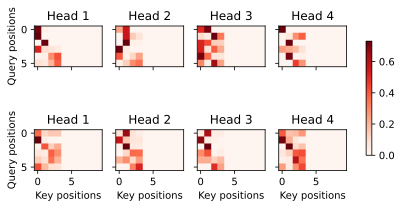

In [20]:
d2l.show_heatmaps(dec_inter_attention_weights, xlabel='Key positions',
                  ylabel='Query positions',
                  titles=['Head %d' % i
                          for i in range(1, 5)], figsize=(7, 3.5))

尽管变压器架构最初是为了顺序到序列的学习而提出的，但正如我们将在本书后面发现的那样，变压器编码器或变压器解码器通常被单独用于不同的深度学习任务。

## 摘要

* 变压器是编码器解码器架构的一个实例，尽管在实践中可以单独使用编码器或解码器。
* 在变压器中，多头自我注意力用于表示输入序列和输出序列，尽管解码器必须通过蒙版本保留自动回归属性。
* 变压器中的残余连接和层标准化对于训练非常深入的模型都很重要。
* 变压器模型中的向定位前馈网络使用相同的 MLP 转换所有序列位置的表示。

## 练习

1. 在实验中训练更深的变压器。它如何影响培训速度和翻译绩效？
1. 在变压器中用添加剂注意力取代缩放的点产品注意力是不错的主意吗？为什么？
1. 对于语言建模，我们应该使用 Transor 编码器、解码器还是两者？如何设计这种方法？
1. 如果输入序列很长，变形金刚会面临什么挑战？为什么？
1. 如何提高变形金刚的计算和内存效率？Hind: you may refer to the survey paper by Tay et al. :cite:`Tay.Dehghani.Bahri.ea.2020`。
1. 我们如何在不使用 CNN 的情况下为图像分类任务设计基于变压器的模型？Hind: you may refer to the Vision Transformer :cite:`Dosovitskiy.Beyer.Kolesnikov.ea.2021`。


[Discussions](https://discuss.d2l.ai/t/1066)
